In [4]:
import os
import zipfile
import datetime
import wget
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Download the Data

In [7]:
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
file = wget.download(url)

In [8]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [6]:
#get info about data
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Preparing Data

In [7]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Setting up callbacks

In [8]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [9]:
#Pretrained model urls

resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-classification/2"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [10]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')     
  ])

  return model

Resnet Model

In [11]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='/tensorflow_hub',
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: /tensorflow_hub/resnet50V2/20240623-015832
Epoch 1/5
24/24 [==============================] - 26s 669ms/step - loss: 2.6419 - accuracy: 0.3187 - val_loss: 1.3071 - val_accuracy: 0.5644
Epoch 2/5
24/24 [==============================] - 13s 556ms/step - loss: 1.0458 - accuracy: 0.6760 - val_loss: 0.9535 - val_accuracy: 0.6776
Epoch 3/5
24/24 [==============================] - 13s 556ms/step - loss: 0.7216 - accuracy: 0.7720 - val_loss: 0.8564 - val_accuracy: 0.7108
Epoch 4/5
24/24 [==============================] - 13s 559ms/step - loss: 0.5584 - accuracy: 0.8267 - val_loss: 0.8139 - val_accuracy: 0.7248
Epoch 5/5
24/24 [==============================] - 13s 561ms/step - loss: 0.4477 - accuracy: 0.8653 - val_loss: 0.8035 - val_accuracy: 0.7292


In [12]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.8035 - accuracy: 0.7292


[0.8035029768943787, 0.729200005531311]

In [13]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

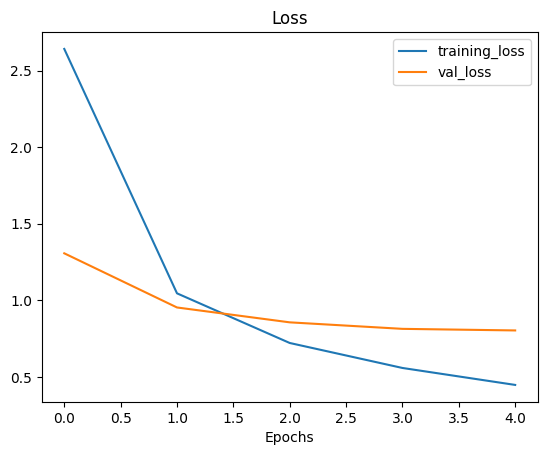

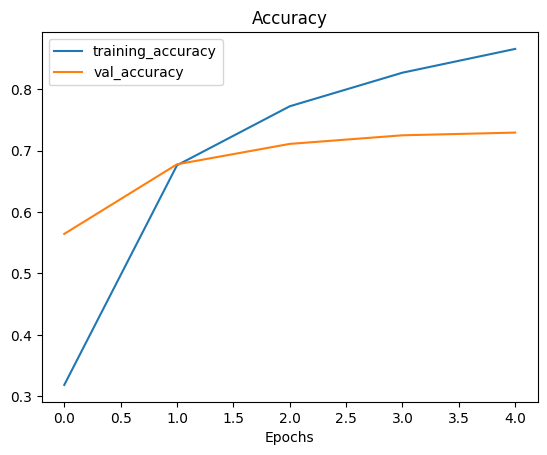

In [14]:
plot_loss_curves(resnet_history)

In [15]:
efficientnet_model = create_model(model_url=efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="/tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: /tensorflow_hub/efficientnetB0/20240623-020027
Epoch 1/5
24/24 [==============================] - 25s 574ms/step - loss: 1.8750 - accuracy: 0.4253 - val_loss: 1.3114 - val_accuracy: 0.7416
Epoch 2/5
24/24 [==============================] - 10s 446ms/step - loss: 1.0630 - accuracy: 0.7720 - val_loss: 0.8687 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 10s 446ms/step - loss: 0.7517 - accuracy: 0.8387 - val_loss: 0.6961 - val_accuracy: 0.8504
Epoch 4/5
24/24 [==============================] - 10s 447ms/step - loss: 0.6030 - accuracy: 0.8720 - val_loss: 0.6076 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 11s 452ms/step - loss: 0.5093 - accuracy: 0.8960 - val_loss: 0.5570 - val_accuracy: 0.8668


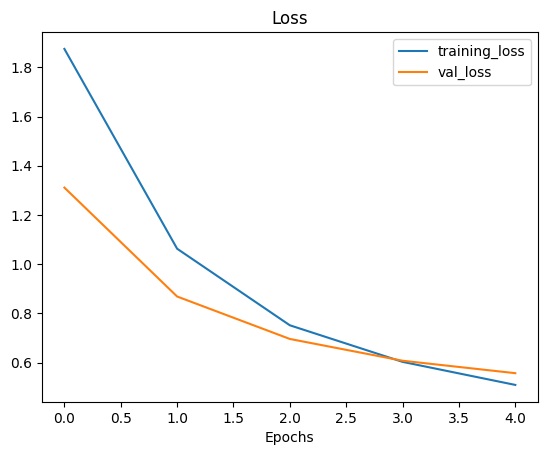

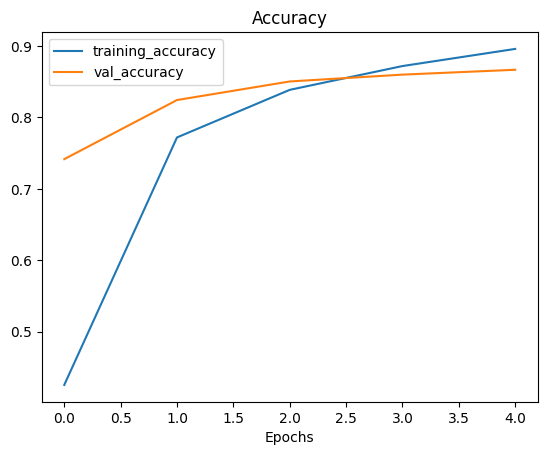

In [16]:
plot_loss_curves(efficientnet_history)